# Artificial Intelligence, 2023/2024

## Assignment No. 2: Supervised Learning

### The Dataset

The dataset consists of 78,600 records, each representing a financial transaction within the Open Metaverse. It encompasses various attributes such as timestamps, sender and receiver addresses, transaction amounts, types, geographical regions, IP addresses, user behaviors, and risk scores. Transactions are labeled as low, medium, or high risk.

For more details about the dataset, refer to its official Kaggle page: [Metaverse Financial Transactions Dataset](https://www.kaggle.com/datasets/faizaniftikharjanjua/metaverse-financial-transactions-dataset)

### The Task

The main goal is to select a robust machine learning model capable of identifying suspicious and potentially fraudulent transactions within the Open Metaverse blockchain network. The model should predict the risk level of a transaction based on the available attributes. 

### Authors

**Group_A2_21**

- **Duarte Gonçalves** up202108772
- **Marco Vilas Boas** up202108774


---

### First Steps

#### Importing Libraries

Let's start by importing the necessary libraries. 

If you haven't installed the required libraries yet, you can do so by running the following command, in the project's root directory:

```python
pip install -r requirements.txt
```

We'll also be disabling warnings for better readability.

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

#### Loading the Dataset

Next, we'll load the dataset and display the first few rows to understand its structure.

In [3]:
data = pd.read_csv('../data/metaverse_transactions.csv')

data.head()

,timestamp,hour_of_day,sending_address,receiving_address,amount,transaction_type,location_region,ip_prefix,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
0,2022-04-11 12:47:27,12,0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da,0x39f82e1c09bc6d7baccc1e79e5621ff812f50572,796.949206,transfer,Europe,192.000,3,48,focused,established,18.75,low_risk
1,2022-06-14 19:12:46,19,0xd6e251c23cbf52dbd472f079147873e655d8096f,0x51e8fbe24f124e0e30a614e14401b9bbfed5384c,0.010000,purchase,South America,172.000,5,61,focused,established,25.00,low_risk
2,2022-01-18 16:26:59,16,0x2e0925b922fed01f6a85d213ae2718f54b8ca305,0x52c7911879f783d590af45bda0c0ef2b8536706f,778.197390,purchase,Asia,192.168,3,74,focused,established,31.25,low_risk
3,2022-06-15 09:20:04,9,0x93efefc25fcaf31d7695f28018d7a11ece55457f,0x8ac3b7bd531b3a833032f07d4e47c7af6ea7bace,300.838358,transfer,South America,172.000,8,111,high_value,veteran,36.75,low_risk
4,2022-02-18 14:35:30,14,0xad3b8de45d63f5cce28aef9a82cf30c397c6ceb9,0x6fdc047c2391615b3facd79b4588c7e9106e49f2,775.569344,sale,Africa,172.160,6,100,high_value,veteran,62.50,moderate_risk



---

### Data Preprocessing

#### Statistical Summary

First, we will generate a statistical summary of the dataset to understand the distribution of the attributes. This will help us identify outliers, and any other anomalies that may require further investigation.

In [4]:
data.describe()

,hour_of_day,amount,ip_prefix,login_frequency,session_duration,risk_score
count,78600.000000,78600.000000,78600.000000,78600.000000,78600.000000,78600.000000
mean,11.532634,502.574903,147.644430,4.178702,69.684606,44.956722
std,6.935897,245.898146,69.388143,2.366038,40.524476,21.775365
min,0.000000,0.010000,10.000000,1.000000,20.000000,15.000000
25%,6.000000,331.319966,172.000000,2.000000,35.000000,26.250000
50%,12.000000,500.029500,172.160000,4.000000,60.000000,40.000000
75%,18.000000,669.528311,192.000000,6.000000,100.000000,52.500000
max,23.000000,1557.150905,192.168000,8.000000,159.000000,100.000000


#### Handling Missing Values

We will then check for missing values and handle them accordingly.

In [5]:
data.isnull().sum()

timestamp            0
hour_of_day          0
sending_address      0
receiving_address    0
amount               0
transaction_type     0
location_region      0
ip_prefix            0
login_frequency      0
session_duration     0
purchase_pattern     0
age_group            0
risk_score           0
anomaly              0
dtype: int64

Since there are no missing values in the dataset, we can proceed with the subsequent steps.

#### Removing Unnecessary Columns

We will drop any columns that are not relevant to the task at hand, aiming to reduce data dimensionality and enhance the model's performance.

These columns generally include unique identifiers, timestamps, and other irrelevant attributes. The decision to remove a column should be guided by domain knowledge and the dataset's nature. In this scenario, we expect that the sender and receiver addresses, along with the IP prefix, will not be useful for predicting the risk level of a transaction.

In [6]:
data = data.drop(['sending_address', 'receiving_address', 'ip_prefix'], axis=1)

data.shape

(78600, 11)

#### Data Distribution

Before proceeding with any additional data manipulation, let's visualize the distribution of the various variables in the dataset. This will provide us with a clearer understanding of the data and offer insights to inform our preprocessing steps.

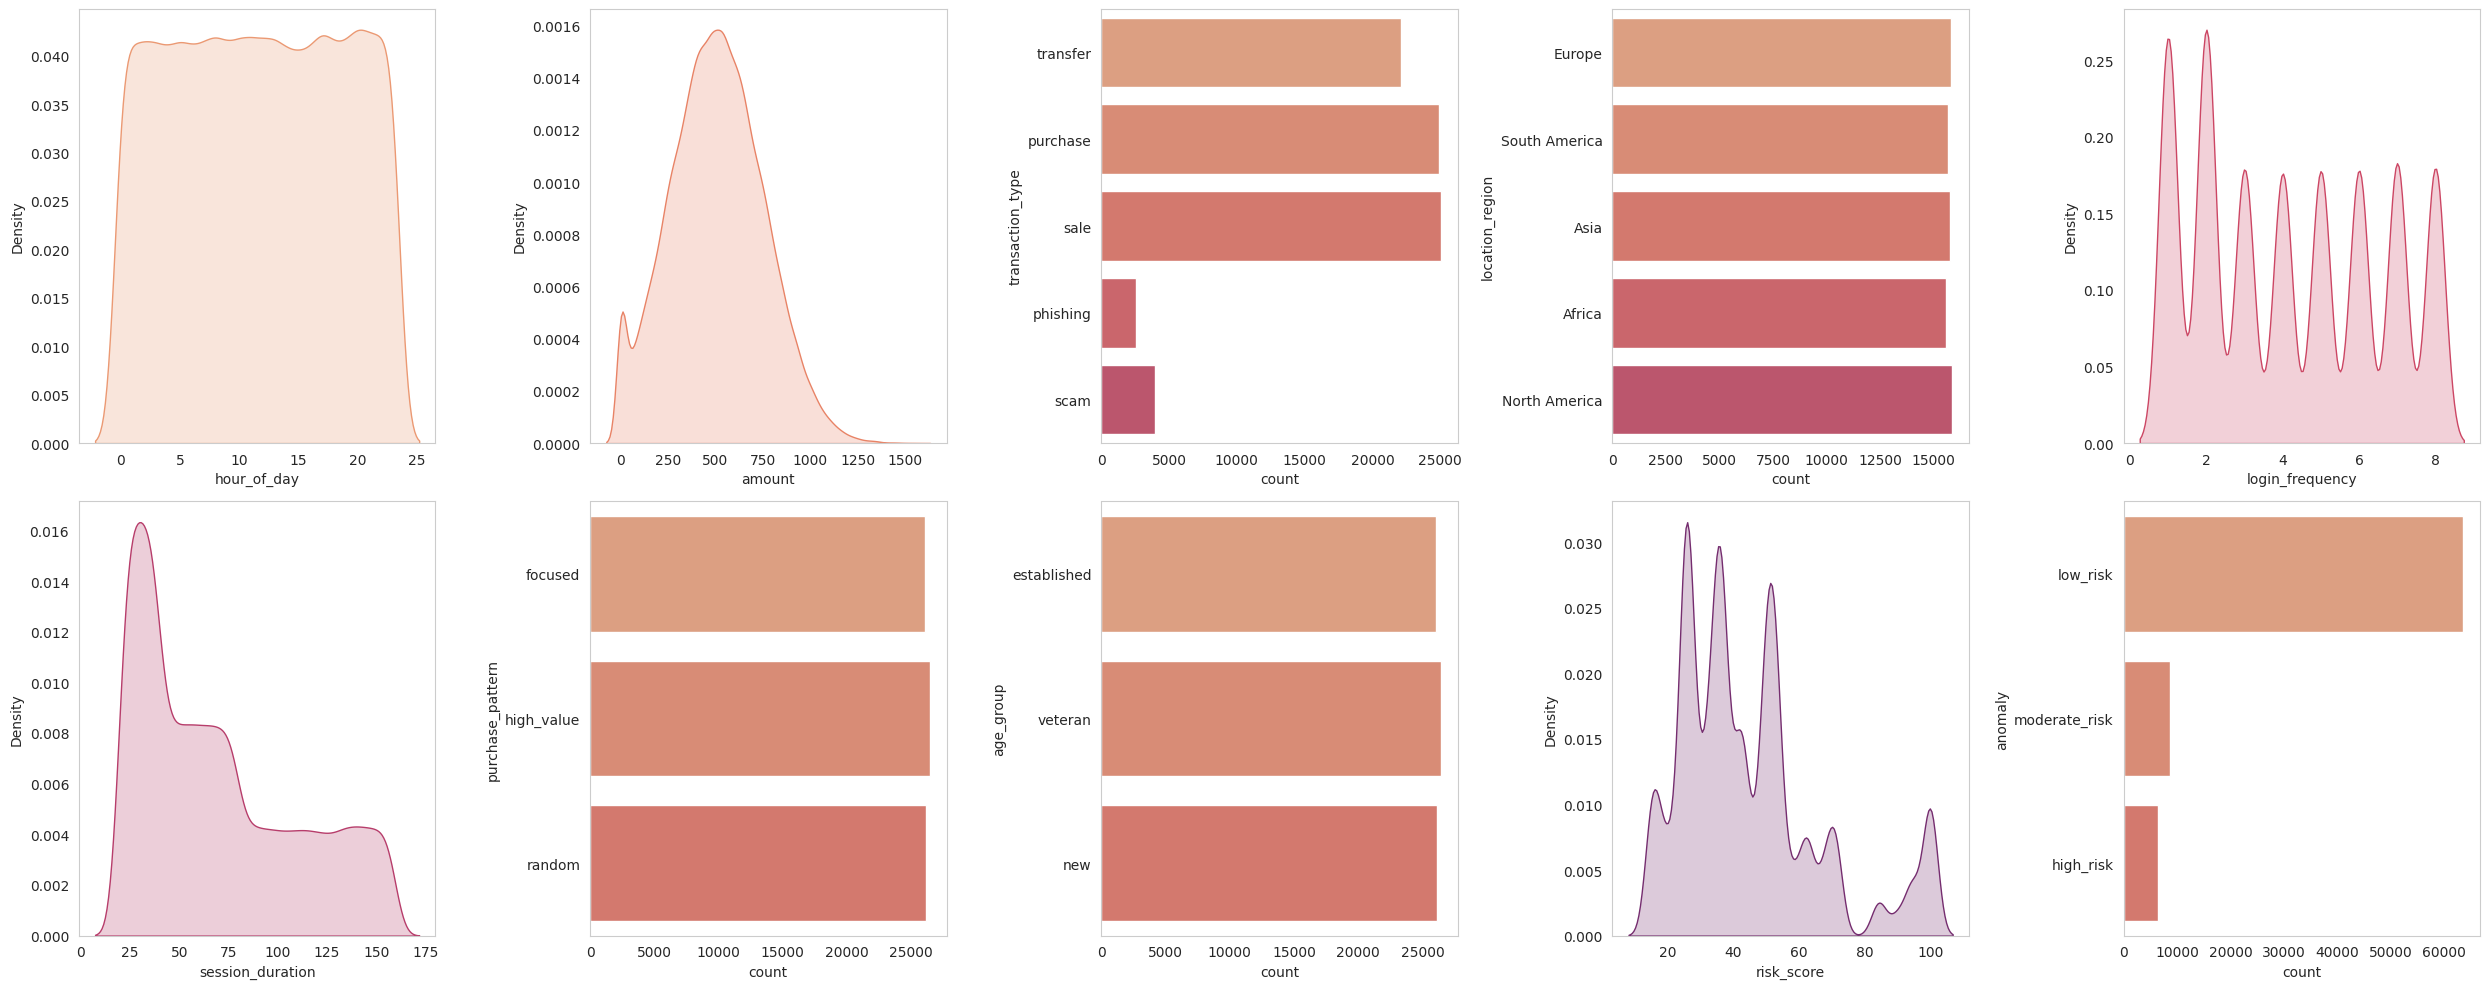

In [7]:
columns = data.columns[1:] # Excluding the 'timestamp' column

r, c = 2, 5

plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

sns.set_style('whitegrid')
palette = sns.color_palette('flare', len(columns))

for i, col in enumerate(columns):
    plt.subplot(r, c, i+1)

    if data[col].dtype == 'object':
        sns.countplot(data[col], palette=palette)
    else:
        sns.kdeplot(data[col], color=palette[i], fill=True)

    plt.grid(False)
     
plt.tight_layout()
plt.show()

Here are some key observations:

- The target variable, 'anomaly', is imbalanced, with a higher number of 'low-risk' transactions. This imbalance may affect the model's performance, and we may need to address it later.
- There seems to be a correlation between the distributions of the 'anomaly', 'risk_score', and 'is_fraud' columns, suggesting a potential relationship among these variables.
- The 'amount' variable may dominate the model's predictions due to its scale. We may need to normalize or standardize this variable to ensure that all features contribute equally to the model's predictions.

#### Feature Engineering

Based on our initial analysis, we'll engineer new features to enhance the model's understanding of the data. This may involve creating additional columns, combining existing ones, or applying meaningful transformations.

Firstly, we'll introduce a new column 'day_of_week' by extracting the day of the week from the timestamp. This can help the model capture any temporal patterns present in the data.

In [8]:
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data = data.drop('timestamp', axis=1)

Additionally, the 'transaction_type' column indicates the nature of the transaction, such as 'transfer', 'purchase', 'sale', 'phishing', or 'scam'. We'll create a new column 'is_fraud' to flag potentially fraudulent transactions, specifically 'phishing' and 'scam' transactions.

In [9]:
data['is_fraud'] = data['transaction_type'].apply(lambda x: 1 if x in ['scam', 'phishing'] else 0)
data = data.drop('transaction_type', axis=1)

Let's see the what the data looks like after these transformations.

In [10]:
data.head()

,hour_of_day,amount,location_region,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly,day_of_week,is_fraud
0,12,796.949206,Europe,3,48,focused,established,18.75,low_risk,0,0
1,19,0.010000,South America,5,61,focused,established,25.00,low_risk,1,0
2,16,778.197390,Asia,3,74,focused,established,31.25,low_risk,1,0
3,9,300.838358,South America,8,111,high_value,veteran,36.75,low_risk,2,0
4,14,775.569344,Africa,6,100,high_value,veteran,62.50,moderate_risk,4,0


#### Encoding Categorical Variables

We need to encode categorical variables to transform them into a format suitable for model training. For ordinal categorical variables, it is essential to use encoding methods that preserve the order of the categories.

In [11]:
# Ordinal categorical variables
data['anomaly'] = data['anomaly'].map({'low_risk': 0, 'moderate_risk': 1, 'high_risk': 2})
data['age_group'] = data['age_group'].map({'new': 0, 'established': 1, 'veteran': 2})

# Nominal categorical variables
for col in ['location_region', 'purchase_pattern']:
    data[col] = data[col].astype('category').cat.codes  # Convert to numerical (label encoding)

data.head()

,hour_of_day,amount,location_region,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly,day_of_week,is_fraud
0,12,796.949206,2,3,48,0,1,18.75,0,0,0
1,19,0.010000,4,5,61,0,1,25.00,0,1,0
2,16,778.197390,1,3,74,0,1,31.25,0,1,0
3,9,300.838358,4,8,111,1,2,36.75,0,2,0
4,14,775.569344,0,6,100,1,2,62.50,1,4,0


#### Identifying Outliers

Outliers can significantly impact the performance of machine learning models. We will use Isolation Forest to identify and handle outliers.

Note: The contamination parameter in Isolation Forest specifies the proportion of outliers in the dataset. This parameter may need adjustment based on the dataset's characteristics. Since outliers in this context may indicate fraudulent transactions, we will set the contamination to a low value of 0.01.

In [12]:
iso = IsolationForest(contamination=0.01)

yhat = iso.fit_predict(data)  # -1 for outliers, 1 for inliers

mask = yhat != -1 # Mask for inliers

data = data[mask] # Remove outliers

data.shape

(77814, 11)


---

### Data Analysis

We will analyze the data to understand the relationships between the attributes and the target variable. This will help us identify patterns and correlations that can inform our model training. To begin, let's visualize how the different attributes are distributed with respect to the target variable.

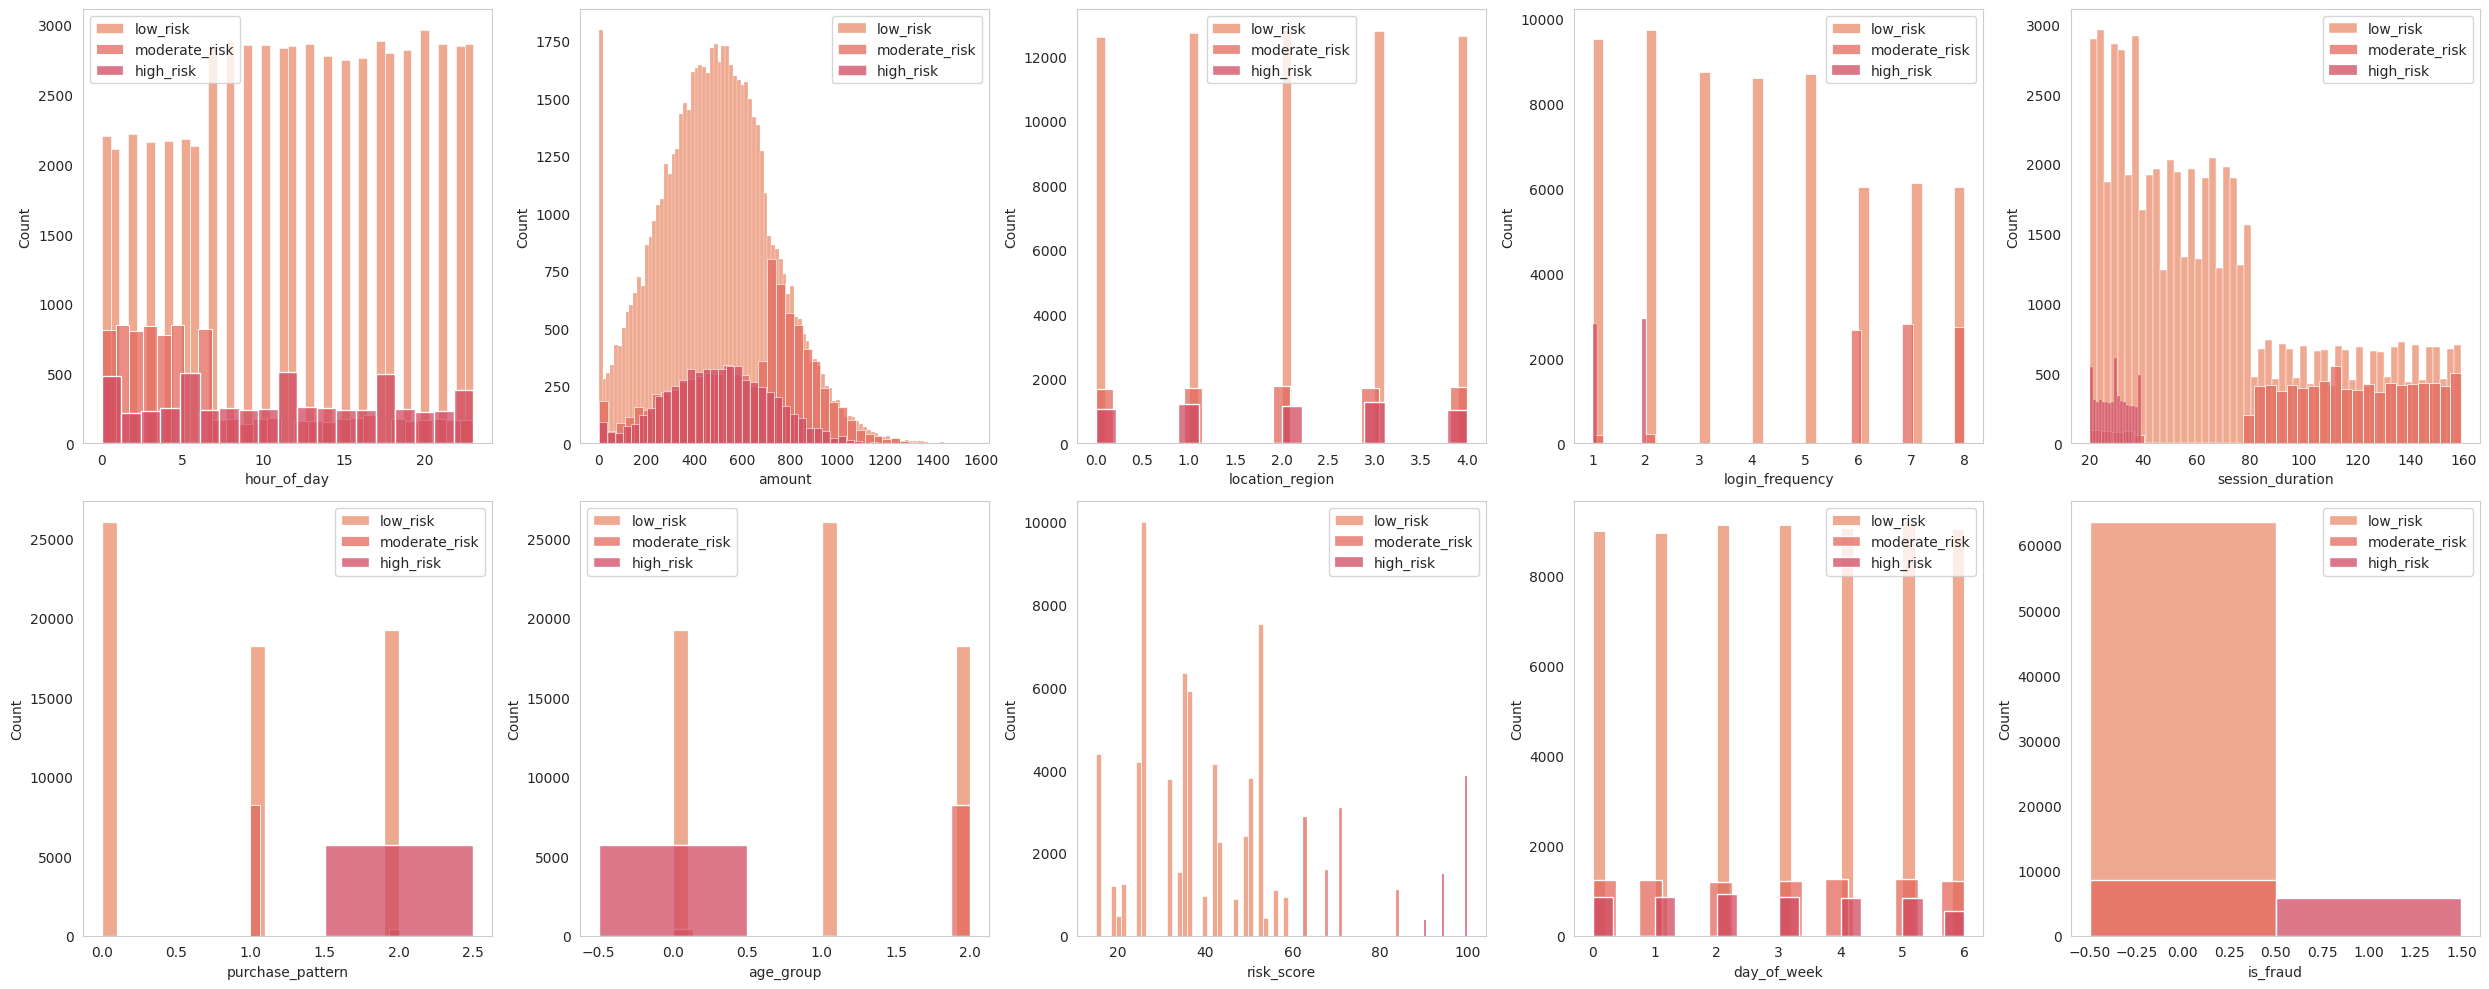

In [13]:
df0 = data[data['anomaly'] == 0].drop('anomaly', axis=1)    # Low risk
df1 = data[data['anomaly'] == 1].drop('anomaly', axis=1)    # Moderate risk
df2 = data[data['anomaly'] == 2].drop('anomaly', axis=1)    # High risk

r, c = 2, 5

plt.figure(figsize=(25, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

sns.set_style('whitegrid')
palette = sns.color_palette('flare')

for i, col in enumerate(df0.columns):
    plt.subplot(r, c, i+1)
    
    sns.histplot(df0[col], color=palette[0], label='low_risk')
    sns.histplot(df1[col], color=palette[1], label='moderate_risk')
    sns.histplot(df2[col], color=palette[2], label='high_risk')
    
    plt.grid(False)
    plt.legend()

plt.tight_layout()
plt.show()

<Axes: >

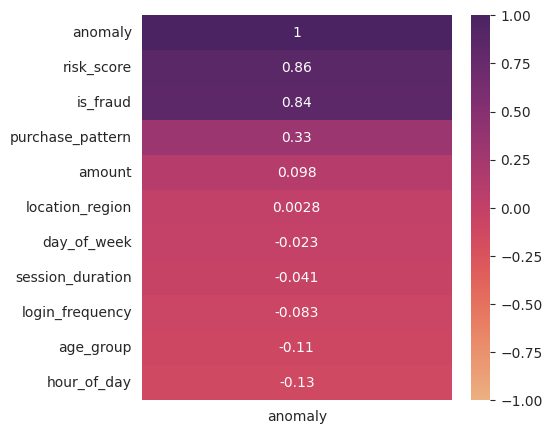

In [14]:
plt.figure(figsize=(5, 5))

corr = data.corr()[['anomaly']].sort_values(by='anomaly', ascending=False)
sns.heatmap(corr, annot=True, cmap='flare', vmin=-1, vmax=1)

The 'risk_score' and 'is_fraud' columns are highly correlated with the target variable, indicating that these attributes are strong predictors of the transaction risk level. To prevent data leakage—where the model is given information it wouldn't have in a real-world scenario—we will drop these columns.

In [15]:
data = data.drop(['risk_score', 'is_fraud'], axis=1)

data.shape

(77814, 9)

#### Class Imbalance

As mentioned earlier, we've observed that the target variable 'anomaly' is imbalanced. We will address this issue later on, during model training.

In [16]:
data['anomaly'].value_counts()

anomaly
0    63494
1     8599
2     5721
Name: count, dtype: int64


---

### Model Selection

#### Splitting the Data

We'll split the data into features (X) and the target variable (y).

In [17]:
X = data.drop('anomaly', axis=1)
y = data['anomaly']

#### Model Training and Evaluation

We will train several models and evaluate their performance using accuracy, precision, recall and F1-score. To ensure consistent performance across different subsets of the data, we will employ 5-fold cross-validation.

To address class imbalance and potential scaling issues, we will use a pipeline for model training. This approach allows us to apply preprocessing steps systematically before training the model. The pipeline will include the following steps:

1. Scale the data using StandardScaler
2. Handle class imbalance using SMOTE
3. Train the model

Scaling the data is crucial for models sensitive to the scale of input features, such as SVMs, KNN, and neural networks. It is also important to scale the data within the cross-validation loop to prevent data leakage.

Synthetic Minority Over-sampling Technique is a popular method for addressing class imbalance by generating synthetic samples for the minority class. Combining SMOTE with cross-validation ensures that the model is trained on balanced data across different folds.

Alternatively, Random Oversampling can be used, which is less computationally expensive but may be more prone to overfitting since it involves simply duplicating minority class samples.

Under-sampling techniques, which reduce the number of majority class samples, can also be employed to balance the dataset. However, under-sampling may lead to a loss of information, potentially impacting the model's performance.

In [18]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),  # max_iter=10000 to avoid convergence warning
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(max_iter=10000),  # SVM is computationally expensive, take a long time to converge
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Multi-layer Perceptron': MLPClassifier(), 
    'XGBoost': XGBClassifier()
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scaler = StandardScaler()
smote = SMOTE(random_state=42)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

results = {}
cross_val_scores = {}

for name, model in models.items():

    print(f'Running {name}...')
    
    # Create a pipeline
    pipeline = Pipeline(steps=[('scaler', scaler), ('smote', smote), (name, model)])
    
    # n_jobs=-1 to utilize all available cores
    scores = cross_validate(pipeline, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
    
    results[name] = {
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision_macro'].mean(),
        'recall': scores['test_recall_macro'].mean(),
        'f1': scores['test_f1_macro'].mean()
    }

    cross_val_scores[name] = scores['test_accuracy']

Running Logistic Regression...
Running Decision Tree...
Running K-Nearest Neighbors...
Running Support Vector Machine...


/home/marco-vb/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/marco-vb/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/marco-vb/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/marco-vb/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/marco-vb/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: Convergence

Running Naive Bayes...
Running Random Forest...
Running Gradient Boosting...
Running AdaBoost...
Running Bagging...
Running Extra Trees...
Running Multi-layer Perceptron...


/home/marco-vb/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marco-vb/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Running XGBoost...


In [19]:
pd.DataFrame(results).T

,accuracy,precision,recall,f1
Logistic Regression,0.633344,0.563112,0.822414,0.570156
Decision Tree,0.815059,0.602654,0.614051,0.607940
K-Nearest Neighbors,0.756830,0.595511,0.757087,0.635051
Support Vector Machine,0.695029,0.607512,0.852143,0.628976
Naive Bayes,0.513519,0.512050,0.788051,0.472726
Random Forest,0.828116,0.620569,0.703549,0.653785
Gradient Boosting,0.776942,0.624356,0.784192,0.664572
AdaBoost,0.668324,0.551933,0.590184,0.460918
Bagging,0.842599,0.606114,0.613866,0.603315
Extra Trees,0.821626,0.617213,0.683223,0.644671


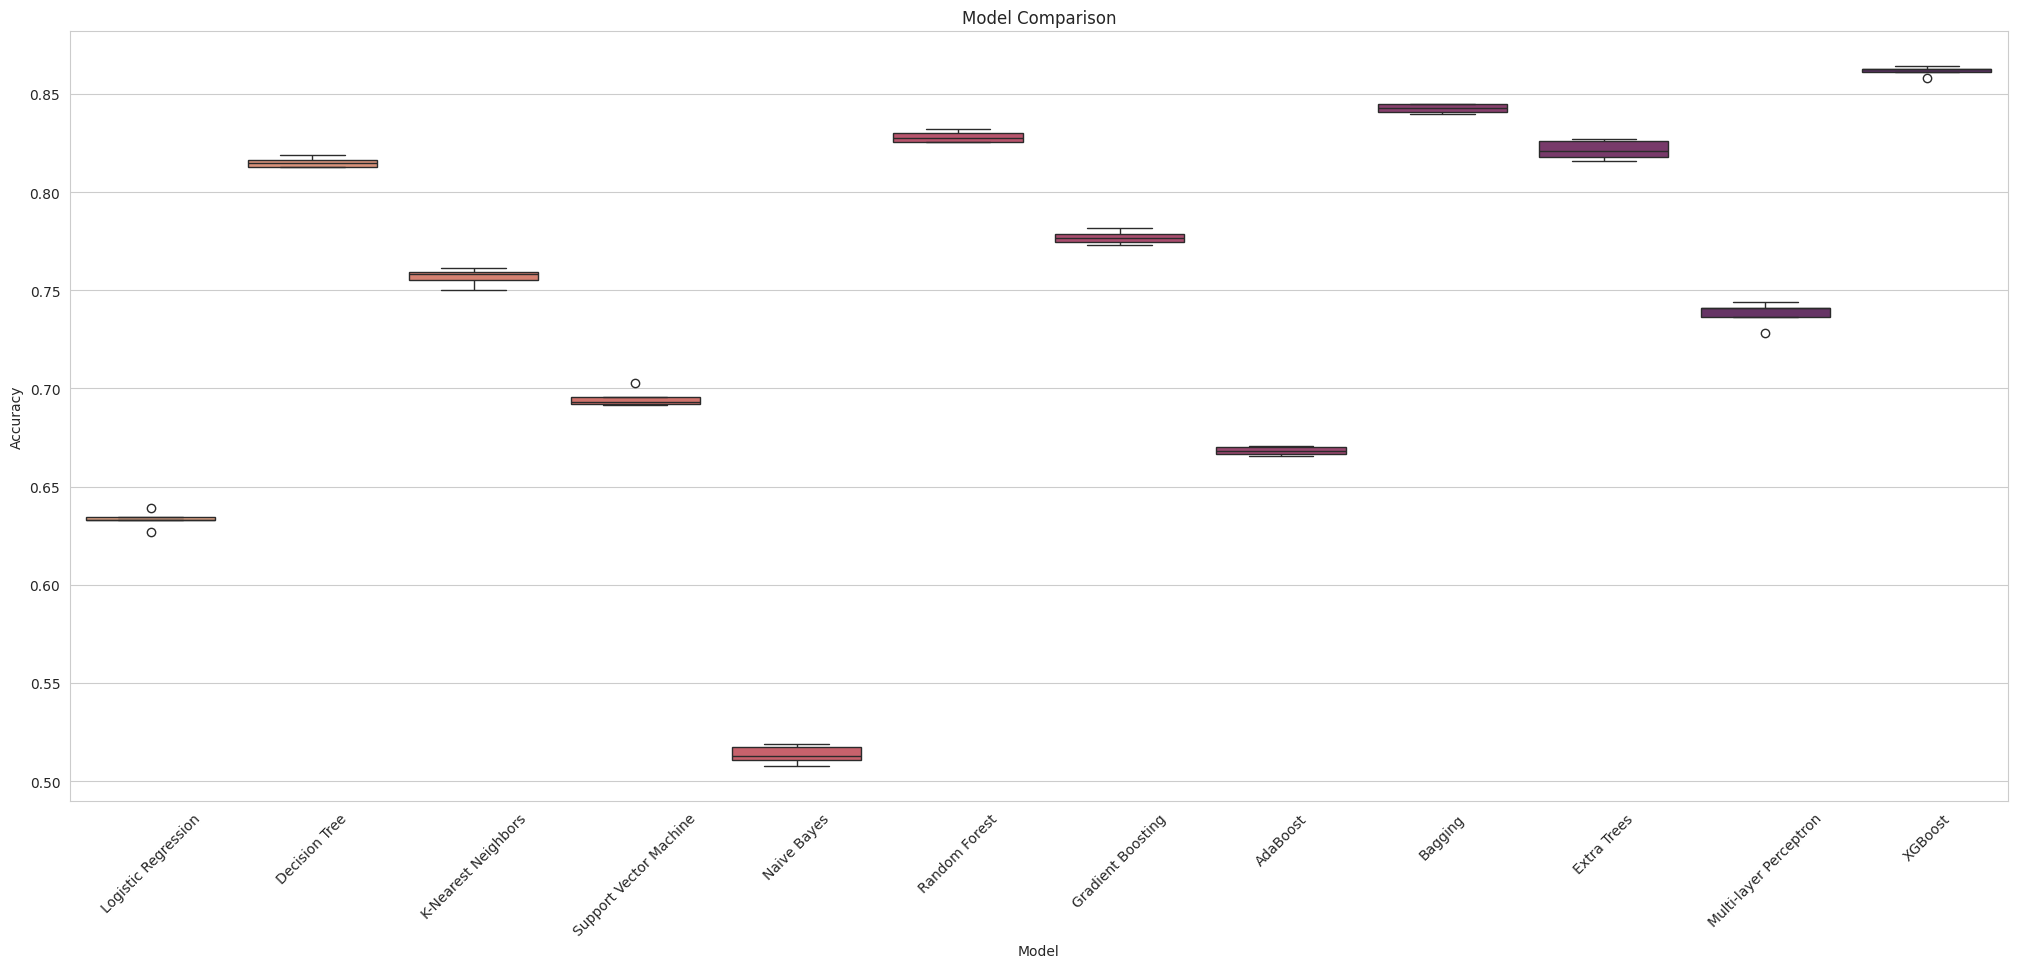

In [20]:
plt.figure(figsize=(25, 10))

sns.boxplot(data=pd.DataFrame(cross_val_scores), palette='flare')

plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')

plt.xticks(rotation=45)

plt.show()

#### Selecting the Best Model

Given the balanced nature of the dataset, we will use accuracy as the primary metric for model evaluation. However, it is crucial to also consider other metrics such as precision, recall, and F1-score to ensure the model generalizes well to unseen data.

Out of the various models we trained, XGBoost has proven to be the best-performing one. XGBoost, or Extreme Gradient Boosting, is an ensemble learning method known for its speed and effectiveness in classification tasks. It uses a gradient boosting framework and combines the predictions of multiple weak learners, typically decision trees, to form a strong predictor.

To illustrate the model's performance, let's visualize it using a confusion matrix.

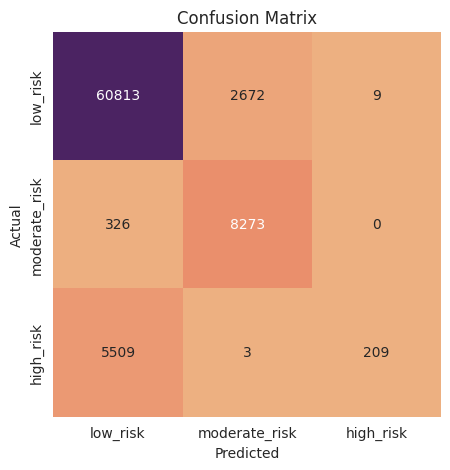

In [21]:
model = XGBClassifier()
model.fit(X, y)

yhat = model.predict(X) # Predictions

confusion = confusion_matrix(y, yhat)


plt.figure(figsize=(5, 5))

labels = ['low_risk', 'moderate_risk', 'high_risk']
sns.heatmap(confusion, annot=True, cmap='flare', fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()